In [1]:
import pandas as pd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Create initial datasets

### Setup input/output

In [23]:
# set base directory
cdir = os.path.dirname(os.getcwd())
baseDIR = os.path.dirname(cdir)
# set input directory
inDIR = 'data'

# set output directory
outDIR = 'data'
if not os.path.exists(os.path.join(baseDIR, outDIR)):
    os.mkdir(os.path.join(baseDIR, outDIR))

# set input file
inXLSX = 'Duchardt_Robel_TBNG_2015-2019.xlsx'

### Load data

In [24]:
# create an Excel file object for investigating contents
nex_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX))

# display the sheet names in the .xlsx file
display(nex_xlsx.sheet_names)

['Metadata', 'Sheet2']

In [25]:
df_duch_vor = nex_xlsx.parse(sheet_name='Sheet2', header=0)

In [5]:
df_duch_vor = pd.wide_to_long(
    df_duch_vor.drop(columns=['Avg Robel (h)', 'Avg Robel (l)']).rename(columns={
        'R1(h)': 'High_cm_R1',
        'R1(l)': 'Low_cm_R1',
        'R2(h)': 'High_cm_R2',
        'R2(l)': 'Low_cm_R2',
        'R1spp': 'Spp_R1',
        'R2spp': 'Spp_R2'}),
    stubnames=['Low_cm', 'High_cm', 'Spp'],
    i=['Transect', 'Point',
       'Easting', 'Northing',
       'Robel type', 'Veg_date', 'pt_year', 'Year'],
    j='Reading',
    sep='_',
    suffix='.*').reset_index()

In [6]:
df_duch_vor

,Transect,Point,Easting,Northing,Robel type,Veg_date,pt_year,Year,Reading,direction,Low_cm,High_cm,Spp
0,C1,C1.1,486913,4813259,0m,2015-07-23,C1.1_2015,2015,R1,45.0,0.0,7,BARE
1,C1,C1.1,486913,4813259,0m,2015-07-23,C1.1_2015,2015,R2,45.0,9.0,24,OPPO
2,C1,C1.1,486913,4813259,10m,2015-07-23,C1.1_2015,2015,R1,45.0,1.0,10,BARE
3,C1,C1.1,486913,4813259,10m,2015-07-23,C1.1_2015,2015,R2,45.0,10.0,12,OPPO
4,C1,C1.1,486913,4813259,15m,2015-07-23,C1.1_2015,2015,R1,45.0,0.0,3,BARE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26291,L9,L9.8,502687,4822914,25m,2019-06-18,L9.8_2019,2019,R2,270.0,12.0,40,BROME
26292,L9,L9.8,502687,4822914,30m,2019-06-18,L9.8_2019,2019,R1,270.0,10.0,26,C3P
26293,L9,L9.8,502687,4822914,30m,2019-06-18,L9.8_2019,2019,R2,270.0,4.0,24,C3P
26294,L9,L9.8,502687,4822914,5m,2019-06-18,L9.8_2019,2019,R1,270.0,26.0,52,C3P


In [7]:
# create list of species to drop from VOR data
vor_spp_drop_list = ['ATCA', 'atca', 'OPPO', 'oppo', 'ARTR', 'artr', 'SD ARTR', 'ARCA', 'arca', 'SD ATCA']

# get total number of vor obs per site
vor_reading_cts = df_duch_vor.groupby(
    ['Transect', 'Point', 
     'Easting', 'Northing',
     'Veg_date', 'pt_year', 'Year']).count()['Reading']

# drop VOR readings in species list
df_duch_vor = df_duch_vor[~df_duch_vor['Spp'].isin(vor_spp_drop_list)]

# convert 'High_cm back to integer'
#df_duch_vor['High_cm'][df_duch_vor['High_cm'] == '90+'] = 90
#df_duch_vor['High_cm'] = df_duch_vor['High_cm'].astype('int')

# drop VOR where low > high as suspected data entry errors
df_duch_vor = df_duch_vor[df_duch_vor['Low_cm'] <= df_duch_vor['High_cm']]

# get percentage of readings remaining after dropping species
vor_reading_pct = (df_duch_vor.groupby(
    ['Transect', 'Point', 
     'Easting', 'Northing',
     'Veg_date', 'pt_year', 'Year']).count()['Reading'] / vor_reading_cts).reset_index()

# get mean of each experimental unit
df_duch_vor_agg = df_duch_vor.groupby(
    ['Transect', 'Point', 
     'Easting', 'Northing',
     'Veg_date', 'pt_year', 'Year']).mean().reset_index()

# get percent of valid herbaceous readings
df_duch_vor_agg['vor_reading_pct'] = vor_reading_pct['Reading']

# drop any sites where < 50% of readings are valid
df_duch_vor_agg = df_duch_vor_agg[df_duch_vor_agg['vor_reading_pct'] > 0.5]

In [8]:
df_duch_vor_agg

,Transect,Point,Easting,Northing,Veg_date,pt_year,Year,direction,Low_cm,High_cm,vor_reading_pct
0,C1,C1.1,486913,4813259,2015-07-23,C1.1_2015,2015,45.0,0.444444,7.888889,0.642857
1,C1,C1.1,486913,4813259,2016-06-29,C1.1_2016,2016,45.0,0.900000,9.500000,0.714286
2,C1,C1.1,486913,4813259,2017-07-06,C1.1_2017,2017,45.0,2.083333,18.916667,0.857143
3,C1,C1.1,486913,4813259,2018-06-18,C1.1_2018,2018,45.0,4.818182,27.909091,0.785714
4,C1,C1.1,486913,4813259,2019-06-13,C1.1_2019,2019,45.0,6.400000,33.300000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1873,L9,L9.7,502687,4823164,2019-06-18,L9.7_2019,2019,90.0,4.818182,28.000000,0.785714
1874,L9,L9.8,502687,4822914,2015-06-17,L9.8_2015,2015,270.0,7.222222,28.222222,0.785714
1875,L9,L9.8,502687,4822914,2016-07-19,L9.8_2016,2016,270.0,3.500000,18.666667,0.642857
1876,L9,L9.8,502687,4822914,2017-07-10,L9.8_2017,2017,270.0,0.857143,25.571429,0.857143


In [9]:
df_duch_vor_agg.to_csv(os.path.join(baseDIR, outDIR, 'TB_duch_vor.csv'), index=False)

In [10]:
mod_vor = pickle.load(open(os.path.join(baseDIR, 'models/vor_linreg_both.pk'), 'rb'))

In [11]:
df_duch_vor_agg['bm_pred'] = round(mod_vor.predict(df_duch_vor_agg), 2)

<AxesSubplot:xlabel='Year', ylabel='bm_pred'>

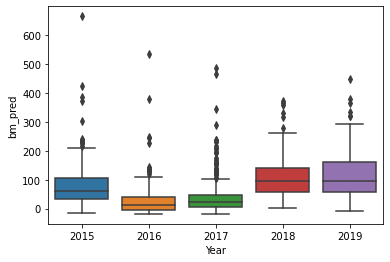

In [12]:
sns.boxplot(x='Year', y='bm_pred', data=df_duch_vor_agg)